
# Raw Vibration → Features → Fault Classification

This notebook builds a full predictive maintenance pipeline from **raw vibration signals**:

1. Load raw `.mat` vibration files (CWRU-style data)  
2. Split long signals into smaller chunks  
3. Extract simple features from each chunk  
4. Build a feature table  
5. Train a Random Forest model to classify fault type  
6. Evaluate the model


In [35]:
# Install dependencies if needed (uncomment if running fresh)
# !pip install numpy pandas scipy scikit-learn matplotlib seaborn joblib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.io as sio
from scipy.stats import skew, kurtosis

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from joblib import dump

print("Imports done.")

Imports done.


## 1. Configuration

In [36]:
# === CONFIGURATION ===
# If this notebook is in 'notebooks/' and your .mat files are in '../data/raw/',
# then this path is correct. Otherwise, change RAW_DIR to your actual folder.
RAW_DIR = "../data/raw"

OUTPUT_FEATURE_CSV = "../data/processed/feature_from_raw.csv"
CHUNK_SIZE = 2048                # samples per chunk
TEST_SIZE = 0.2                  # 20% test split
RANDOM_STATE = 42
# =======================

print("Current working directory:", os.getcwd())
print("Configured RAW_DIR:", RAW_DIR)
print("Absolute RAW_DIR:", os.path.abspath(RAW_DIR))

if not os.path.isdir(RAW_DIR):
    print("\n⚠️ RAW_DIR does NOT exist. Fix the path above.")
else:
    print("\n✅ RAW_DIR exists.")
    print("Files in RAW_DIR:", os.listdir(RAW_DIR))

Current working directory: c:\Users\SIL-Laptop\Desktop\MQI\Portfolio\Sensemore\Predictive_Maintenance_Machine_Failure_Prediction_from_Vibration\notebooks
Configured RAW_DIR: ../data/raw
Absolute RAW_DIR: c:\Users\SIL-Laptop\Desktop\MQI\Portfolio\Sensemore\Predictive_Maintenance_Machine_Failure_Prediction_from_Vibration\data\raw

✅ RAW_DIR exists.
Files in RAW_DIR: ['B007_1_123.mat', 'B014_1_190.mat', 'B021_1_227.mat', 'IR007_1_110.mat', 'IR014_1_175.mat', 'IR021_1_214.mat', 'OR007_6_1_136.mat', 'OR014_6_1_202.mat', 'OR021_6_1_239.mat', 'Time_Normal_1_098.mat']


## 2. Helper Functions

In [37]:
def load_signal_from_mat(path):
    """Load vibration signal from a CWRU-style .mat file and return 1D numpy array."""
    mat = sio.loadmat(path)
    # pick non-internal keys (ignore __header__, __version__, __globals__)
    keys = [k for k in mat.keys() if not k.startswith('__')]
    if len(keys) == 0:
        raise ValueError(f"No valid data keys found in {path}. Keys: {list(mat.keys())}")
    signal = mat[keys[0]].squeeze()
    if signal.ndim != 1:
        signal = signal.ravel()
    return signal

# Quick sanity check
if os.path.isdir(RAW_DIR):
    sample_files = [f for f in os.listdir(RAW_DIR) if f.endswith('.mat')]
    print("Sample .mat files:", sample_files[:5])
    if not sample_files:
        print("⚠️ No .mat files found in RAW_DIR. Put your .mat files there.")
else:
    print("⚠️ Cannot list .mat files because RAW_DIR is missing.")

Sample .mat files: ['B007_1_123.mat', 'B014_1_190.mat', 'B021_1_227.mat', 'IR007_1_110.mat', 'IR014_1_175.mat']


In [38]:
def chunk_signal(signal, chunk_size=2048):
    """Split 1D signal into non-overlapping chunks of length chunk_size."""
    signal = np.asarray(signal)
    n = len(signal)
    chunks = []
    for start in range(0, n - chunk_size + 1, chunk_size):
        chunk = signal[start:start+chunk_size]
        chunks.append(chunk)
    return np.array(chunks)

In [39]:
def extract_features_from_chunk(chunk):
    """Return a dict of simple features from a 1D chunk."""
    chunk = np.asarray(chunk)
    rms = np.sqrt(np.mean(chunk**2))
    features = {
        "max": float(np.max(chunk)),
        "min": float(np.min(chunk)),
        "mean": float(np.mean(chunk)),
        "std": float(np.std(chunk)),
        "rms": float(rms),
        "skewness": float(skew(chunk)),
        "kurtosis": float(kurtosis(chunk)),
        "crest": float(np.max(chunk) / (rms + 1e-8)),  # crest factor
    }
    return features

In [40]:
def parse_labels_from_filename(filename):
    """Return (fault_raw, fault_simple) from a .mat filename."""
    base = os.path.splitext(filename)[0]  # remove .mat
    parts = base.split('_')
    
    # Normal case
    if base.startswith("Time_Normal") or "Normal" in parts:
        return "Normal", "Normal"
    
    # Ball fault (e.g. B007_...)
    if base.startswith("B"):
        return parts[0], "Ball"
    
    # Inner race fault (e.g. IR007_...)
    if base.startswith("IR"):
        return parts[0], "InnerRace"
    
    # Outer race fault (e.g. OR007_...)
    if base.startswith("OR"):
        return parts[0], "OuterRace"
    
    # Fallback: use first token
    return parts[0], parts[0]

## 3. Build Feature Table from Raw Signals

In [41]:
all_rows = []

if not os.path.isdir(RAW_DIR):
    raise RuntimeError(f"RAW_DIR does not exist: {RAW_DIR}. Fix the path in the config cell.")

mat_files = [f for f in os.listdir(RAW_DIR) if f.endswith('.mat')]
print(f"Found {len(mat_files)} .mat files in RAW_DIR.")

if not mat_files:
    raise RuntimeError("No .mat files found in RAW_DIR. Put your vibration .mat files there.")

for fname in mat_files:
    path = os.path.join(RAW_DIR, fname)
    try:
        signal = load_signal_from_mat(path)
    except Exception as e:
        print(f"⚠️ Skipping {fname} due to error while loading: {e}")
        continue
    
    chunks = chunk_signal(signal, chunk_size=CHUNK_SIZE)
    if len(chunks) == 0:
        print(f"⚠️ No chunks produced for {fname} (signal too short?). Skipping.")
        continue
    
    fault_raw, fault_simple = parse_labels_from_filename(fname)
    
    for chunk in chunks:
        feats = extract_features_from_chunk(chunk)
        feats["fault_raw"] = fault_raw
        feats["fault"] = fault_simple
        all_rows.append(feats)

df = pd.DataFrame(all_rows)
print("Feature DataFrame shape:", df.shape)
df.head()

Found 10 .mat files in RAW_DIR.
Feature DataFrame shape: (2608, 10)


,max,min,mean,std,rms,skewness,kurtosis,crest,fault_raw,fault
0,0.359862,-0.418900,0.017840,0.122716,0.124006,-0.118659,-0.039330,2.901958,B007,Ball
1,0.467716,-0.361113,0.022255,0.132456,0.134312,0.174825,-0.078699,3.482303,B007,Ball
2,0.468550,-0.438092,0.020470,0.149614,0.151008,0.040369,-0.271400,3.102820,B007,Ball
3,0.584749,-0.543026,0.020960,0.157029,0.158422,-0.023283,0.137756,3.691090,B007,Ball
4,0.446854,-0.578908,0.022167,0.138155,0.139922,-0.081593,0.406102,3.193590,B007,Ball


In [42]:
print("Label distribution (fault simple):")
print(df["fault"].value_counts())

print("\nLabel distribution (fault_raw):")
print(df["fault_raw"].value_counts())

os.makedirs(os.path.dirname(OUTPUT_FEATURE_CSV), exist_ok=True)
df.to_csv(OUTPUT_FEATURE_CSV, index=False)
print("\nSaved feature table to:", OUTPUT_FEATURE_CSV)

Label distribution (fault simple):
fault
InnerRace    950
Ball         711
OuterRace    711
Normal       236
Name: count, dtype: int64

Label distribution (fault_raw):
fault_raw
IR014     477
OR021     238
B014      237
B007      237
IR007     237
B021      237
OR007     237
IR021     236
OR014     236
Normal    236
Name: count, dtype: int64

Saved feature table to: ../data/processed/feature_from_raw.csv


## 4. Train/Test Split and Model Training

In [43]:
LABEL_COL = "fault"

X = df.drop(columns=[LABEL_COL, "fault_raw"])
y = df[LABEL_COL]

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)
print("Classes:", y.unique())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Feature matrix shape: (2608, 8)
Target shape: (2608,)
Classes: ['Ball' 'InnerRace' 'OuterRace' 'Normal']
Train size: 2086
Test size: 522


In [ ]:
# Encode string labels to integers for model training (raw → features pipeline)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

class_names = le.classes_

print("Encoded classes:", class_names)
print("y_train_enc shape:", y_train_enc.shape)
print("y_test_enc shape:", y_test_enc.shape)


In [44]:
model = RandomForestClassifier(
    n_estimators=400,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced"
)

model.fit(X_train, y_train)
print("Model trained!")

Model trained!


## 5. Evaluation

=== Classification Report ===
              precision    recall  f1-score   support

        Ball       0.96      0.92      0.94       143
   InnerRace       0.98      1.00      0.99       190
      Normal       1.00      0.98      0.99        47
   OuterRace       0.94      0.95      0.94       142

    accuracy                           0.96       522
   macro avg       0.97      0.96      0.97       522
weighted avg       0.96      0.96      0.96       522



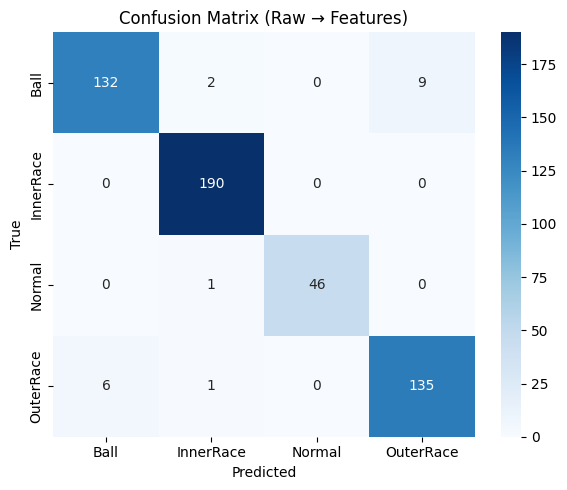

In [45]:
y_pred = model.predict(X_test)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title("Confusion Matrix (Raw → Features)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

## 6. Feature Importance

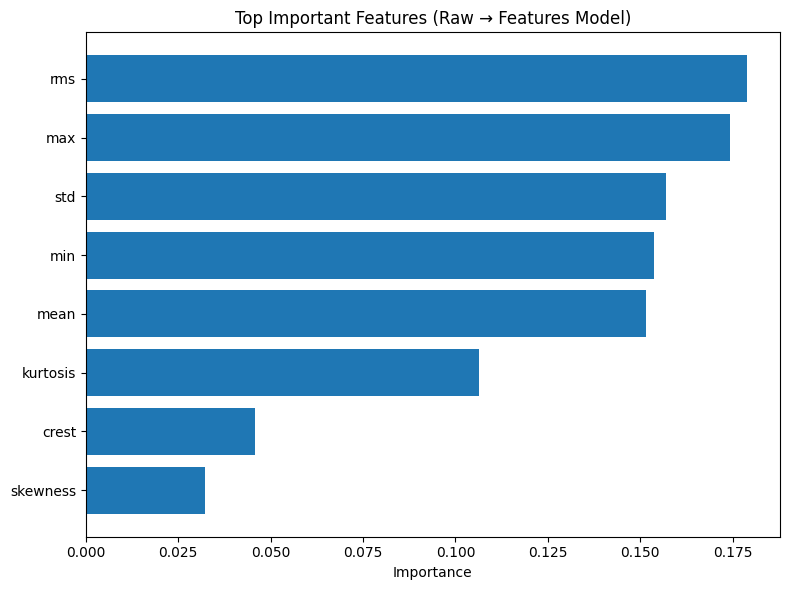

In [46]:
importances = model.feature_importances_
feature_names = X.columns

indices = np.argsort(importances)[-15:]

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title("Top Important Features (Raw → Features Model)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## 7. Save Model (Optional)

In [47]:
OUTPUT_DIR = "../results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

model_path = os.path.join(OUTPUT_DIR, "rf_from_raw_signals.joblib")
dump(model, model_path)

print(f"Model saved to: {model_path}")

Model saved to: ../results\rf_from_raw_signals.joblib


In [ ]:
# --- Extra models & metrics for comparison (raw → features notebook) ---
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier  # make sure xgboost is installed
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

print("Additional model imports done (raw pipeline).")

In [ ]:
# --- Helper: unified evaluation for multiple models (raw pipeline, with label encoding) ---
results_multi = []  # separate from quick notebook

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize

def evaluate_model_raw(name, clf, X_train, X_test, y_train_enc, y_test_enc):
    """
    Fit, evaluate, and log metrics for a given classifier (raw → features).

    y_train_enc, y_test_enc: integer-encoded labels.
    We'll decode to original labels for reports.
    Also saves the confusion matrix plot to disk for later use in reports/README.
    """
    print(f"\n===== {name} =====")
    
    # Fit on encoded labels
    clf.fit(X_train, y_train_enc)
    
    # Predict encoded labels
    y_pred_enc = clf.predict(X_test)
    
    # Decode back to original string labels
    y_true = le.inverse_transform(y_test_enc)
    y_pred = le.inverse_transform(y_pred_enc)
    
    acc = accuracy_score(y_true, y_pred)
    print("Accuracy:", acc)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    plt.figure(figsize=(5.5, 4.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {name} (raw → features)")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    
    # Save confusion matrix plot
    os.makedirs("../results/confusion_matrices", exist_ok=True)
    safe_name = name.replace(" ", "_").replace("(", "").replace(")", "")
    out_path = os.path.join("../results/confusion_matrices", f"raw_cm_{safe_name}.png")
    plt.savefig(out_path, bbox_inches="tight")
    print(f"Saved confusion matrix plot to: {out_path}")
    
    plt.show()
    
    # ROC-AUC on encoded labels
    auc = np.nan
    try:
        if hasattr(clf, "predict_proba"):
            y_proba = clf.predict_proba(X_test)
        elif hasattr(clf, "decision_function"):
            y_proba = clf.decision_function(X_test)
        else:
            y_proba = None
        
        if y_proba is not None:
            classes_enc = np.arange(len(class_names))
            if len(classes_enc) > 2:
                y_test_bin = label_binarize(y_test_enc, classes=classes_enc)
                auc = roc_auc_score(y_test_bin, y_proba, multi_class="ovr")
            else:
                if y_proba.ndim == 2 and y_proba.shape[1] == 2:
                    auc = roc_auc_score(y_test_enc, y_proba[:, 1])
                else:
                    auc = roc_auc_score(y_test_enc, y_proba)
    except Exception as e:
        print("Could not compute ROC-AUC:", e)
    
    print("ROC-AUC:", auc)
    
    results_multi.append({
        "model": name,
        "accuracy": acc,
        "roc_auc": auc
    })
    
    return clf


In [ ]:
# --- Define and evaluate several models on the raw → features dataset ---
models_raw = {
    "Random Forest": RandomForestClassifier(
        n_estimators=400,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight="balanced"
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob" if len(np.unique(y_train_enc)) > 2 else "binary:logistic",
        eval_metric="mlogloss",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    "SVM (RBF)": SVC(
        kernel="rbf",
        C=10,
        gamma="scale",
        probability=True,
        random_state=RANDOM_STATE
    ),
    "Logistic Regression": LogisticRegression(
        max_iter=2000,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=RANDOM_STATE
    )
}

fitted_models_raw = {}

for name, clf in models_raw.items():
    clf_fitted = evaluate_model_raw(name, clf, X_train, X_test, y_train_enc, y_test_enc)
    fitted_models_raw[name] = clf_fitted

print("\nFinished evaluating all models (raw pipeline).")

In [ ]:
# --- Summarise raw-pipeline model comparison ---
import pandas as pd

results_raw_df = pd.DataFrame(results_multi)
results_raw_df = results_raw_df.sort_values(by="accuracy", ascending=False)
print(results_raw_df)

results_raw_df